<a href="https://colab.research.google.com/github/ZZhiming/Visualize-CNN-Deep-Learning/blob/master/Symposium_Zhiming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Using Pretrained Neural Network to Extract Image Features**


# 1. Extract textures, shapes, colors, objects

# 2. Transfer Learning


Import Tensorflow, Numpy, plotting tools, etc.

In [0]:
import tensorflow as tf
tf.enable_eager_execution()
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

#https://colab.research.google.com/drive/1WthpyM_COgpfYq5rM0Xda-f9QebqGbfj

Define image helper functions and plotting functions

In [0]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

def crop_center(image):
    shape = image.shape
    new_shape = min(shape[1], shape[2])
    offset_y = max(shape[1] - shape[2], 0) // 2
    offset_x = max(shape[2] - shape[1], 0) // 2
    image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
    return image

def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

# Load Pretrained VGG Model

In [0]:
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')


## Model Architecture

<img src="https://i.ibb.co/QK6YZsK/vgg.png" alt="vgg" border="0">


## ImageNet-1000
<img src="https://i.ibb.co/mC5PfFG/imagenet.png" alt="imagenet" border="0">



## Load content image

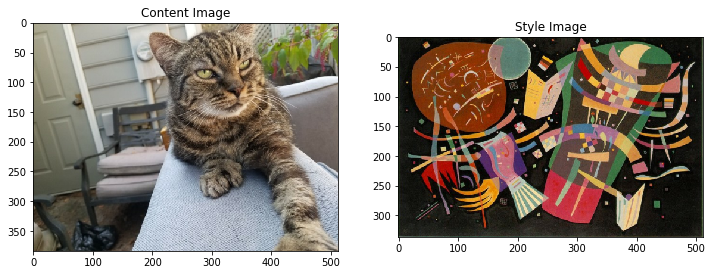

In [0]:
content_path = tf.keras.utils.get_file('cat.jpg', 'https://i.ibb.co/k921WcQ/garrett-cat.jpg')

style_path = tf.keras.utils.get_file('wk.jpg','https://i.ibb.co/JqX11w3/abstract-wk.jpg')

content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')


In [0]:
# content_image = np.random.rand(1,400,400,3)
# content_image = content_image.astype("float32")
# imshow(content_image)

## Use pretrained model for image recognition

In [0]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
prediction_probabilities = vgg(x)
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('tabby', 0.6161343),
 ('tiger_cat', 0.20849666),
 ('Egyptian_cat', 0.07730617),
 ('paper_towel', 0.008898118),
 ('washbasin', 0.008434827)]

## Load VGG model without final classification output layer

In [0]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

## List all layers from model

In [0]:
for layer in vgg.layers:
  print(layer.name)

input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


## Visulize what deep learning is learning:

> Indented block



In [0]:
output = vgg.get_layer('block5_conv2').output
model = tf.keras.Model(vgg.input, output)

(1, 14, 14, 512)
(14, 14)


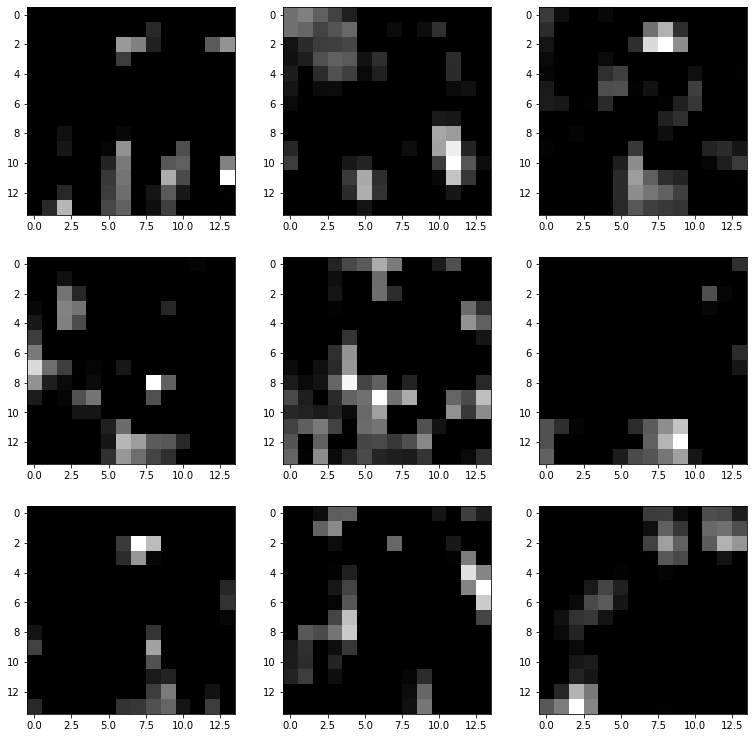

In [0]:

print(model.predict(x).shape)
layer_img = model.predict(x)
img_array = layer_img[0, :, :, 1]
print(img_array.shape)
plt.figure(figsize = (13,13))
plt.set_cmap('gray')

a = np.array(range(layer_img.shape[3]))
np.random.shuffle(a)
for i in range(9):
  idx = a[i]
  img_array = layer_img[0, :, :, idx]
  plt.subplot(3,3,i+1)
  plt.imshow(img_array)
# plt.subplot(1,2,2)
# plt.imshow(img_array)

# Define Content Layers and Style Layers
## Change this to get different visual results

In [0]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv2',
                'block3_conv1', 
                'block4_conv2', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# Define the image generation model, inputs and outputs
## The outputs will be used in the distance function

In [0]:
def vgg_layers(layer_names):  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Test the newyly created model

In [0]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look each style layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  718.45703
  mean:  22.990385

block2_conv2
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  5990.243
  mean:  145.97508

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  6109.2305
  mean:  176.80975

block4_conv2
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  14896.054
  mean:  408.58054

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  2092.9348
  mean:  49.568596



In [0]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}


In [0]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.042245958
    max:  21307.684
    mean:  293.4323

   block2_conv2
    shape:  (1, 128, 128)
    min:  0.05997108
    max:  146414.03
    mean:  7857.281

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.18183868
    max:  202088.48
    mean:  9817.134

   block4_conv2
    shape:  (1, 512, 512)
    min:  0.0
    max:  2308971.2
    mean:  66241.766

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  72941.02
    mean:  1409.6077

Contents:
   block5_conv2
    shape:  (1, 24, 32, 512)
    min:  0.0
    max:  1079.9846
    mean:  15.174619


## Content and Style outputs for distance function

In [0]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

## Define distance function

<img src="https://i.ibb.co/304TZQ6/cd.png" alt="cd" border="0">

In [0]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

## Back propagation setup

## Note: image pixels are now parameters, instead of model weights

## y = a*x

In [0]:
image = tf.Variable(content_image)
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# hyper-parameter, change to get different visual results
style_weight=1e-2
content_weight=1e4

def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

#imshow(style_image, 'Style Image')

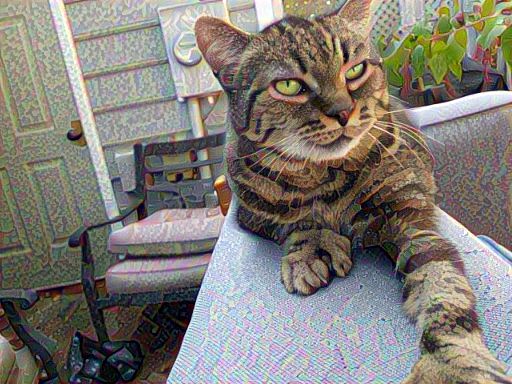

In [0]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)
# for i in range(100):
#   train_step(image)


In [0]:
# for i in range(20000):
#   if (i % 1000)==0:
#     print(i)
#   train_step(image)

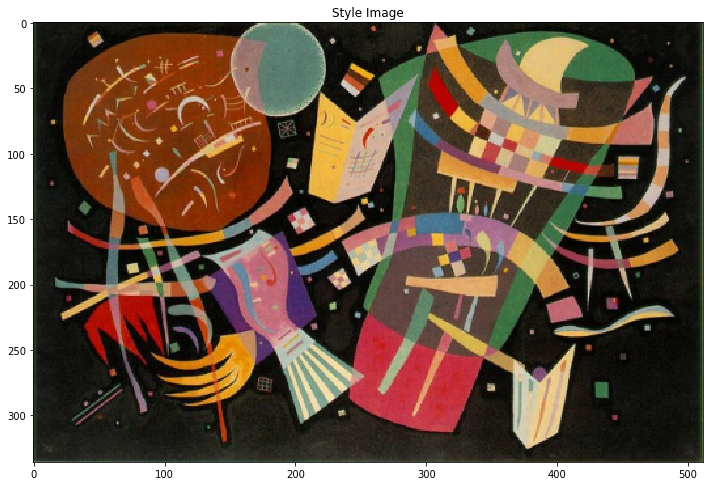

In [0]:
imshow(style_image, 'Style Image')


<img src="https://i.ibb.co/q7fM4nc/cat00.png" alt="cat00" border="0">

<img src="https://i.ibb.co/jvFN7SS/cat01.png" alt="cat01" border="0">

<img src="https://i.ibb.co/5rbSJQv/cat04.png" alt="cat04" border="0">